# COVID19 Vaccination Dashboard
[Cumulative Vaccines Administered by Date](#Cumulative-Vaccines-Administered-by-Date)  
[Vaccines Administered by State](#Vaccines-Administered-by-State)  
[Vaccines Administered by Manufacturer](#Vaccines-Administered-by-Manufacturer)  

In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from IPython.core.display import display, HTML

In [2]:
pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [3]:
data_state = pd.read_csv('us_state_vaccinations.csv')
data_manufac = pd.read_csv('vaccinations-by-manufacturer.csv')

In [4]:
data_state.fillna(method='ffill',inplace=True)
max_perc = lambda x: np.max([i/100 for i in x])
data_state_piv = pd.pivot_table(data_state,
                                index='location',
                                values=['total_vaccinations_per_hundred','people_vaccinated','people_fully_vaccinated_per_hundred','people_fully_vaccinated'],
                               aggfunc={'total_vaccinations_per_hundred':max_perc,
                                       'people_fully_vaccinated_per_hundred':max_perc,
                                       'people_vaccinated':np.max,
                                       'people_fully_vaccinated':np.max})

In [5]:
data_state['date'] = pd.to_datetime(data_state['date'])
data_cumsum_doses = pd.pivot_table(data_state,
                                  index='date',
                                  values=['total_distributed','people_vaccinated','people_fully_vaccinated'],
                                  aggfunc=np.sum)

**As of the most recent data pull:**

In [6]:
print('{:,.0f} vaccines in the United States have been administered'.format(data_cumsum_doses['people_vaccinated'].max()))
print('{:,.0f} people in the United States are fully vaccinated'.format(data_cumsum_doses['people_fully_vaccinated'].max()))

243,517,746 vaccines in the United States have been administered
148,087,914 people in the United States are fully vaccinated


## Cumulative Vaccines Administered by Date
[Back to Top](#COVID19-Vaccination-Dashboard)

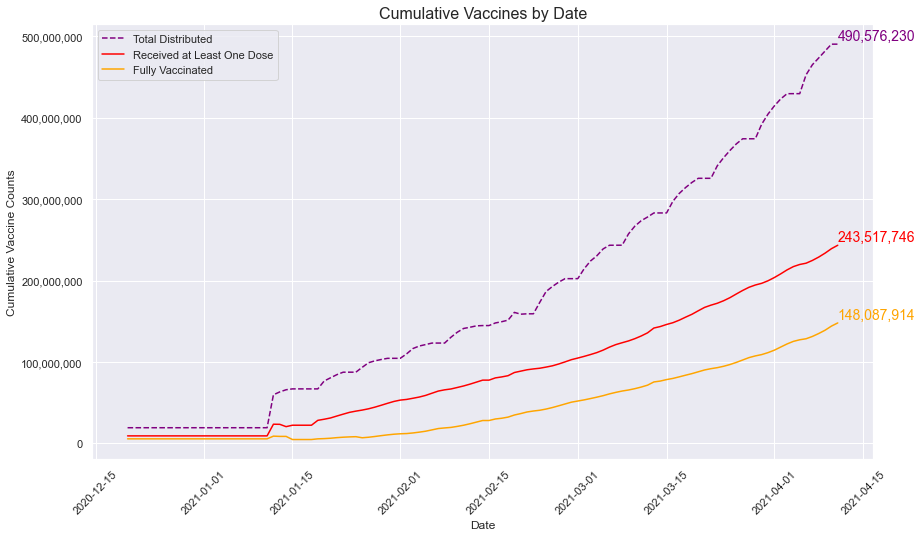

In [7]:
sns.set(rc={'figure.figsize':(14,8)})
ax3 = sns.lineplot(x=data_cumsum_doses.index,y='total_distributed',data=data_cumsum_doses,color='purple',linestyle='--',label='Total Distributed')
sns.lineplot(x=data_cumsum_doses.index,y='people_vaccinated',data=data_cumsum_doses,color='red',label='Received at Least One Dose')
sns.lineplot(x=data_cumsum_doses.index,y='people_fully_vaccinated',data=data_cumsum_doses,color='orange',label='Fully Vaccinated')

above_val = 5000000
plt.text(data_cumsum_doses.index.to_list()[-1], data_cumsum_doses['total_distributed'].max() + above_val, '{:,.0f}'.format(data_cumsum_doses['total_distributed'].max()),size=14,color = 'purple')
plt.text(data_cumsum_doses.index.to_list()[-1], data_cumsum_doses['people_vaccinated'].max() + above_val, '{:,.0f}'.format(data_cumsum_doses['people_vaccinated'].max()),size=14,color = 'red')
plt.text(data_cumsum_doses.index.to_list()[-1], data_cumsum_doses['people_fully_vaccinated'].max() + above_val, '{:,.0f}'.format(data_cumsum_doses['people_fully_vaccinated'].max()),size=14,color = 'orange')

plt.ylabel('Cumulative Vaccine Counts')
plt.xlabel('Date')
plt.title('Cumulative Vaccines by Date',size=16)
plt.xticks(rotation=45) 
ax3.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

## Vaccines Administered by State
[Back to Top](#COVID19-Vaccination-Dashboard)

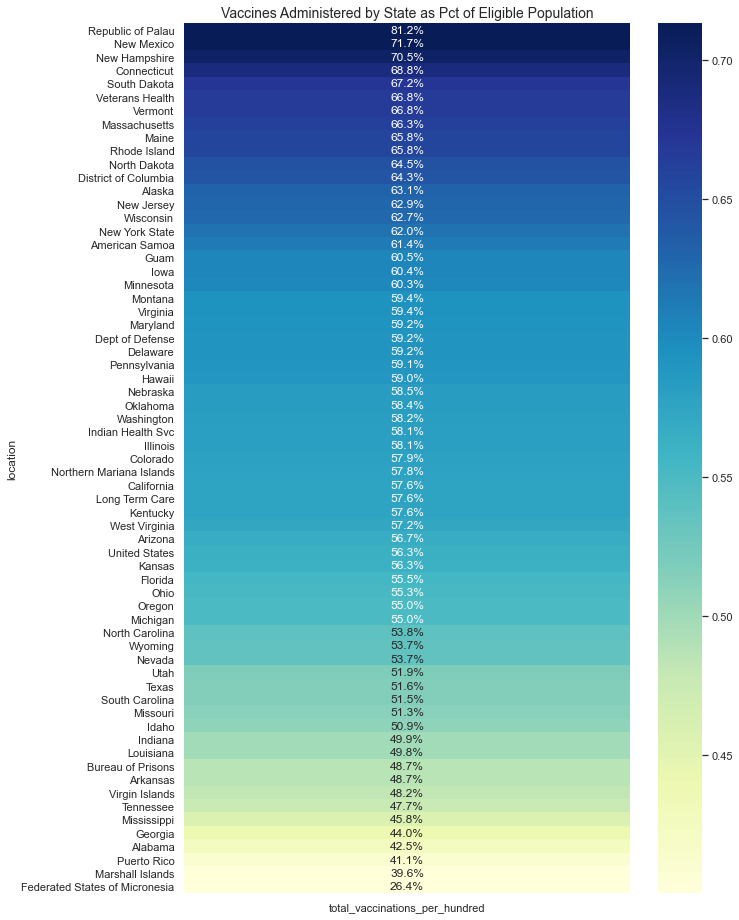

In [8]:
# make this rate by LHD
sns.set(rc={'figure.figsize':(10,16)})
sns.heatmap(data_state_piv[['total_vaccinations_per_hundred']].sort_values('total_vaccinations_per_hundred',ascending=False),cmap="YlGnBu", annot=True, fmt='.1%', robust=True)
#mplcursors.cursor(hover=True)
plt.title('Vaccines Administered by State as Pct of Eligible Population',size=14)
plt.show()

In [9]:
for c in data_state_piv:
    data_state_piv.rename(columns={c:c.replace('per_hundred','percent').replace('_',' ').title()},inplace=True)
data_state_piv_html = data_state_piv[['People Vaccinated','Total Vaccinations Percent','People Fully Vaccinated','People Fully Vaccinated Percent']].to_html(formatters={
        'People Fully Vaccinated':'{:,.0f}'.format,
        'People Fully Vaccinated Percent':'{:,.1%}'.format,
        'People Vaccinated':'{:,.0f}'.format,
        'Total Vaccinations Percent':'{:,.1%}'.format,
    })

display(HTML(data_state_piv_html))

,People Vaccinated,Total Vaccinations Percent,People Fully Vaccinated,People Fully Vaccinated Percent
location,,,,
Alabama,"1,382,951",42.5%,"819,550",16.7%
Alaska,"270,838",63.1%,"198,792",27.2%
American Samoa,"19,406",61.4%,"14,846",26.7%
Arizona,"2,533,121",56.7%,"1,579,065",21.7%
Arkansas,"944,947",48.7%,"567,249",18.8%
Bureau of Prisons,"74,459",48.7%,"53,264",18.8%
California,"15,123,816",57.6%,"8,332,396",21.1%
Colorado,"2,143,097",57.9%,"1,285,768",22.3%
Connecticut,"1,555,580",68.8%,"974,687",27.3%


## Vaccines Administered by Manufacturer
[Back to Top](#COVID19-Vaccination-Dashboard)

In [10]:
data_manufac_us = data_manufac.loc[data_manufac['location'] == 'United States']
data_mpiv = pd.pivot_table(data_manufac_us,
                          index=['date'],
                          columns=['vaccine'],
                          values='total_vaccinations',
                          aggfunc=np.sum,
                          fill_value=0)

data_mpiv['Total'] = data_mpiv[data_mpiv.columns.to_list()].sum(axis=1)
vax = data_mpiv.columns.to_list()

In [11]:
for c in vax:
    data_mpiv[c+' Daily Admin'] = data_mpiv[c].diff(1)
    
data_mpiv['Total 7-day Avg'] = data_mpiv['Total Daily Admin'].rolling(7).mean()

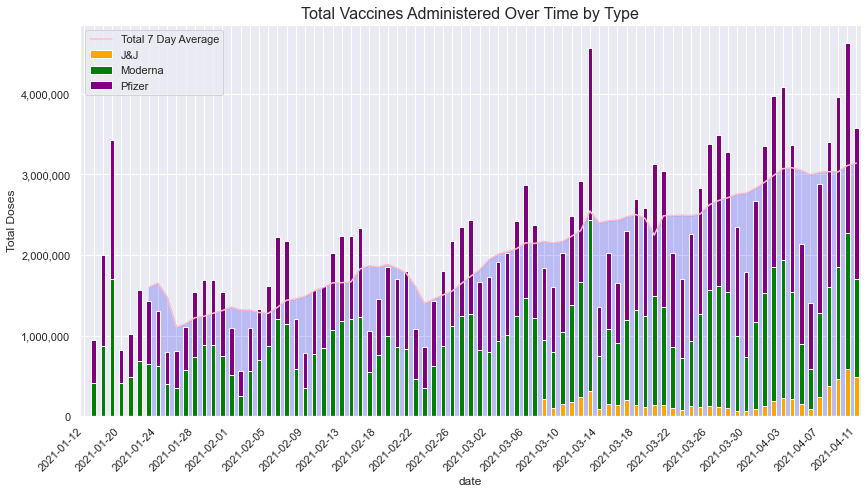

In [12]:
sns.set(rc={'figure.figsize':(14,8)})
_, ax1 = plt.subplots()

data_mpiv.plot(kind='bar',y=[c+' Daily Admin' for c in vax if c != 'Total'],stacked=True,label=['J&J','Moderna','Pfizer'],color=['orange','green','purple'],ax=ax1)
data_mpiv.reset_index().plot(kind='line',y='Total 7-day Avg',color='pink',label='Total 7 Day Average',ax=ax1)

plt.fill_between(data_mpiv.reset_index().index, data_mpiv['Total 7-day Avg'], 0,
                 facecolor="orange", # The fill color
                 color='blue',       # The outline color
                 alpha=0.2)          # Transparency of the fill

# do this to make the dates between the bar and line charts line up
ticklabels = ['']*data_mpiv.shape[0]
for i,v in enumerate(data_mpiv.index):
    if i%4 == 0:
        ticklabels[i] = v
ax1.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
plt.gcf().autofmt_xdate()

plt.xticks(rotation=45)
plt.legend()
plt.ylabel('Total Doses')
plt.title('Total Vaccines Administered Over Time by Type',size=16)
ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

In [13]:
data_total_doses = pd.pivot_table(data_manufac_us,index='vaccine',values='total_vaccinations',aggfunc=np.sum)
data_total_doses.index.names = ['Vaccine Type']
data_total_doses.rename(columns={'total_vaccinations':'Total Doses Administered in US'},inplace=True)
data_total_doses.style.format("{:,.0f}")

,Total Doses Administered in US
Vaccine Type,
Johnson&Johnson,"97,696,539"
Moderna,"3,342,663,721"
Pfizer/BioNTech,"3,634,910,478"
